### Import Libraries

In [14]:
#### We will try an XGBoost Model below for given challenge, so install XGBOOST model 
# (In Anaconda we can either use pip or conda)
# For conda reference- https://stackoverflow.com/questions/35139108/how-to-install-xgboost-in-anaconda-python-windows-platform
# !pip install xgboost

In [19]:
# Import Libraries
import numpy as np
import pandas as pd
# Model libraries
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier # Use XGBClassifier as we have binary classification problem
from sklearn.svm import SVC # Supprot Vector Classifier Model
from sklearn.neighbors import KNeighborsClassifier


# Preprocessing and Pipeline libraries
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder
import pickle

## model accuracy, score and cross validation libraries
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

import time 

## Hide warnings in Jupyert Notebook
import warnings
warnings.filterwarnings('ignore')

### Take a different approach - Fun with data wrangling

*Note- Since there hand selected features (10) are available, skipping feature engineering part*

* Combine and shuffle training and test data
* create a 80-20 train and test split
* Run a cross validation on the training set - This will help to avoid overfitting and underfitting
* Build a model using XGBoost for credit risk prediction
* Deploy the model

### Import Training Data

In [2]:
### Make sure you have are "MLE_Challenge_Project" folder. This allows freedom to change directories and 
### later save files
training_data_file = r"mle-project-challenge\data\peerLoanTraining.csv"

print("\nLoading training data...")
# load training data
training_data = pd.read_csv(training_data_file, engine='python', header=0)
print("\nThere are ", len(training_data), "records in training data")

# Separate out X and y
X_train = training_data.loc[:, training_data.columns != 'is_late']
# y_train = training_data.loc[:,training_data.columns == 'is_late']
y_train = training_data.iloc[:,-1:]


Loading training data...

There are  111068 records in training data


##### Quick Data Exploration

In [3]:
print("There are ",len(X_train.columns), "columns in x_train data")
print("There are ",len(y_train.columns), "columns in y_train data")
training_data.head()

There are  10 columns in x_train data
There are  1 columns in y_train data


,loan_amnt,int_rate,purpose,grade,annual_inc,revol_util,emp_length,dti,delinq_2yrs,home_ownership,is_late
0,12000,0.2039,credit_card,D,42000.0,0.647,10+ years,14.46,0,RENT,0
1,29150,0.2039,home_improvement,D,51000.0,0.404,10+ years,20.82,0,MORTGAGE,0
2,8000,0.1306,other,C,73000.0,0.560,10+ years,33.27,0,MORTGAGE,0
3,21000,0.0746,credit_card,A,60000.0,0.395,NaN,22.42,0,OWN,0
4,13000,0.1747,debt_consolidation,D,27500.0,0.185,4 years,26.45,0,RENT,0


### Import Test Data

In [4]:
test_data_path = r"mle-project-challenge\data\peerLoanTest.csv"

print("\nLoading test data")
test_data = pd.read_csv(test_data_path, engine='python', header=0)
print("\nThere are ", len(test_data), "records in training data")
# Separate out X and y
X_test = test_data.loc[:, test_data.columns != 'is_late']
# y_test = test_data['is_late']
y_test = test_data.iloc[:, -1:]


Loading test data

There are  6843 records in training data


### Append test data into training data

In [5]:
combined_df = training_data.append(test_data, ignore_index=True)

In [6]:
print("Lenght of training data - ", len(training_data))
print("Lenght of test data - ", len(test_data))
print("Combined data should be -", len(training_data) + len(test_data), "and lenght of combined data - ", len(combined_df))
# combined_df

Lenght of training data -  111068
Lenght of test data -  6843
Combined data should be - 117911 and lenght of combined data -  117911


### Shuffle combined_df

In [7]:
## Before shuffle
combined_df.head()

,loan_amnt,int_rate,purpose,grade,annual_inc,revol_util,emp_length,dti,delinq_2yrs,home_ownership,is_late
0,12000,0.2039,credit_card,D,42000.0,0.647,10+ years,14.46,0,RENT,0
1,29150,0.2039,home_improvement,D,51000.0,0.404,10+ years,20.82,0,MORTGAGE,0
2,8000,0.1306,other,C,73000.0,0.560,10+ years,33.27,0,MORTGAGE,0
3,21000,0.0746,credit_card,A,60000.0,0.395,NaN,22.42,0,OWN,0
4,13000,0.1747,debt_consolidation,D,27500.0,0.185,4 years,26.45,0,RENT,0


In [8]:
## After shuffle (set random_state = 1 to get the same seed and create a new df)
combined_df_shuffled = combined_df.sample(frac=1, random_state = 1).reset_index(drop=True)
combined_df_shuffled.head()

,loan_amnt,int_rate,purpose,grade,annual_inc,revol_util,emp_length,dti,delinq_2yrs,home_ownership,is_late
0,10000,0.1090,credit_card,B,55000.0,0.830,NaN,17.95,0,OWN,0
1,26000,0.1747,credit_card,D,64000.0,0.531,10+ years,16.24,0,MORTGAGE,0
2,12000,0.2677,debt_consolidation,E,62000.0,0.505,< 1 year,6.97,0,MORTGAGE,0
3,20000,0.1646,debt_consolidation,C,88000.0,0.220,10+ years,16.46,0,RENT,0
4,20000,0.0796,credit_card,A,65000.0,0.280,2 years,32.39,0,RENT,0


In [9]:
### Write combined_df_shuffled data as a CSV file into the same data folder
# combined_df_shuffled.to_csv(r'mle-project-challenge\data\combined_data.csv', header=True,index=False)

### Separate X, y and cretae Train Test Split (80:20)

In [10]:
# Separate out X and y
X = combined_df_shuffled.loc[:, combined_df_shuffled.columns != 'is_late']
y = combined_df.iloc[:,-1:]  # output a df style in jupyter notebook with index location

In [11]:
## From Sklearn train_test_split function
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

In [12]:
len(X_train)

94328

##### Check outcome varibale normalization

In [13]:
y_train['is_late'].value_counts(normalize=True)

0    0.978299
1    0.021701
Name: is_late, dtype: float64

In [14]:
y_test['is_late'].value_counts(normalize=True)

0    0.978459
1    0.021541
Name: is_late, dtype: float64

In [15]:
### Not too much of a difference from original dataset. This is because we have majority of them are 0's. 

### Data Presprocessing (borrow from what has been already done/given)
###### We have mixed types, therefore, it has a nice pipeline to impute missing data and categorical transformers with onehot encoding

In [16]:
# Assign numeric features from dataset and impute with median for missing data.
numeric_features = ['loan_amnt', 
                    'int_rate', 'annual_inc', 'revol_util', 
                    'dti', 'delinq_2yrs'
                   ]

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ])
# Assign values from dataset
categorical_features = ['purpose','grade', 'emp_length', 'home_ownership']

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

## Main pre-preprocess variable
preprocess = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
        ]
    )

In [17]:
model = make_pipeline(preprocess, RandomForestClassifier(n_estimators = 100, random_state=42))

In [20]:
start_time = time.time()
print("\nTraining model ...")
model.fit(X_train, y_train)
print("\n---Time to train default model %s seconds ---" % (time.time() - start_time))


Training model ...

---Time to train default model 88.3991596698761 seconds ---


In [21]:
prob = model.predict_proba(X_test)
pos_probs = prob[:,0]

In [22]:
from sklearn.metrics import roc_curve, auc
import sklearn.metrics as metrics
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
auc = roc_auc_score(y_test, pos_probs)
print('AUC: %.3f' % auc)

AUC: 0.504


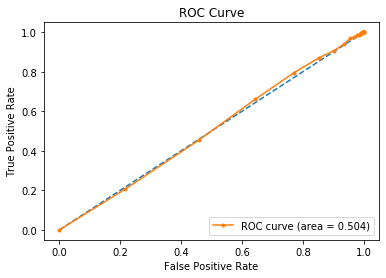

In [27]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, pos_probs)
# plot 
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='.', label = 'ROC curve (area = %0.3f)' % auc)
# plot x, y axis labels
pyplot.xlabel("False Positive Rate")
pyplot.ylabel("True Positive Rate")
pyplot.legend(loc = 'lower right')
pyplot.title("ROC Curve")

# pyplot.savefig("new_model_mle_challenge/img/roc_curve_imp.jpg")
# show the plot
pyplot.show()

In [24]:
print("Accuracy:\n%s" % accuracy_score(y_test, model.predict(X_test)))

Accuracy:
0.978459059492007


In [121]:
## Accuracy went slightly down, however, the AUC score went higher from 0.380 to 0.50

### Test with Pay On Time

In [25]:
# Make a prediction for a likely on time payer
payOnTimePrediction = {
    'loan_amnt': [100],
    'int_rate': [0.02039],
    'purpose': ['credit_card'],
    'grade': ['A'],
    'annual_inc': [80000.00],
    'revol_util': [0.05],
    'emp_length': ['10+ years'],
    'dti': [1.46],
    'delinq_2yrs': [0],
    'home_ownership': ['RENT']
    }
payOnTimePredictionDf = pd.DataFrame.from_dict(payOnTimePrediction)

print("\nPredicting class probabilities for likely on-time payer:")
print(model.predict_proba(payOnTimePredictionDf))


Predicting class probabilities for likely on-time payer:
[[0.93 0.07]]


### Test with Pay Late

In [26]:
# Prediction for a likely late payer
payLatePrediction = {
    'loan_amnt': [10000],
    'int_rate': [0.6],
    'purpose': ['credit_card'],
    'grade': ['D'],
    'annual_inc': [20000.00],
    'revol_util': [0.85],
    'emp_length': ['1 year'],
    'dti': [42.00],
    'delinq_2yrs': [4],
    'home_ownership': ['RENT']
    }
payLatePredictionDf = pd.DataFrame.from_dict(payLatePrediction)

print("\nPredicting class probabilities for a likely late payer:")
print(model.predict_proba(payLatePredictionDf))


Predicting class probabilities for a likely late payer:
[[0.93 0.07]]


## Extra - Try Different Models

### Create a Pipeline and Fit XGBoost Model

In [35]:
model = make_pipeline(preprocess, XGBClassifier())

### Predict With XGBoost Model

In [39]:
import time
start_time = time.time()
print("\nTraining model ...")
model.fit(X_train, y_train)
print("\n---Time for training %s seconds ---" % (time.time() - start_time))


Training model ...

---Time for training 11.792896509170532 seconds ---


In [40]:
print("Accuracy:\n%s" % accuracy_score(y_test, model.predict(X_test)))

Accuracy:
0.978459059492007


### Check accuracy score with K-Fold Validation and See if that improve's model score. Setting K =5
* reference- https://machinelearningmastery.com/evaluate-gradient-boosting-models-xgboost-python/

In [64]:
## create a pipeline
model_with_k_fold = make_pipeline(preprocess, XGBClassifier())

In [77]:
## Test with 5 splits
k_fold = KFold(n_splits=5, random_state=42)

In [78]:
start_time = time.time()
results = cross_val_score(model_with_k_fold, X, y, cv=k_fold)
print("Accuracy: %.2f%% " % (results.mean()*100))
print("\n---Time 5 fold validation %s seconds ---" % (time.time() - start_time))

Accuracy: 97.83% 

---Time 5 fold validation 61.40383768081665 seconds ---


### Test Model Scores in Each Iteration of the Model

In [18]:
# Here k_fold is 5, since we used 5 last time in same variable
scores = []
for train_index, test_index in k_fold.split(X):
    ## Print Training and testing indexes of each K-fold
#     print(len(train_index), len(test_index))
    
    X_train, X_test, y_train, y_test = X.iloc[train_index], X.iloc[test_index], y.iloc[train_index], y.iloc[test_index]
    scores.append(model_with_k_fold.score(X_test, y_test))

In [19]:
print("avgerage score", sum(scores)/len(scores),'\nAll Scores are below:', '\n',scores)

avgerage score 0.9783310832113997 
All Scores are below: 
 [0.9819785438663444, 0.9776100415571198, 0.975023322873378, 0.9789670087354763, 0.9780764990246799]


### Fit model

In [79]:
model_with_k_fold.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='median',
                                                        

#### Accuracy itseld is a good measure, since data is not well balanced, checking ROC-AUC curve will be a good measure

In [80]:
prob = model_with_k_fold.predict_proba(X_test)

In [81]:
# Since 0 is our positive outcome we'll take all the positive outcomes - Approved Loan
pos_probs = prob[:,0]

In [93]:
from sklearn.metrics import roc_curve, auc
import sklearn.metrics as metrics
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
auc = roc_auc_score(y_test, pos_probs)
print('AUC: %.3f' % auc)

AUC: 0.505


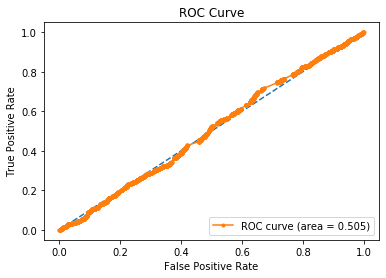

In [99]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, pos_probs)
# plot 
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='.', label = 'ROC curve (area = %0.3f)' % auc)
# plot x, y axis labels
pyplot.xlabel("False Positive Rate")
pyplot.ylabel("True Positive Rate")
pyplot.legend(loc = 'lower right')
pyplot.title("ROC Curve")
# show the plot
pyplot.show()

In [ ]:
## Plot auc is 0.5, wheree 50% of the time the classifier will rank a randomly chosen postive example higher than randomly 
# chosen negative example.
# This is the reason the model almost always gives postive outcome (0)
# For this demo, I am going to leave it 0.5 threshold due to time contraints. 

### Test Model With Sample Data
#####  On time Payer

In [84]:
# Make a prediction for a likely on time payer
payOnTimePrediction = {
    'loan_amnt': [100],
    'int_rate': [0.02039],
    'purpose': ['credit_card'],
    'grade': ['A'],
    'annual_inc': [80000.00],
    'revol_util': [0.05],
    'emp_length': ['10+ years'],
    'dti': [1.46],
    'delinq_2yrs': [0],
    'home_ownership': ['RENT']
    }
payOnTimePredictionDf = pd.DataFrame.from_dict(payOnTimePrediction)
print("\nPredicting class probabilities for likely on-time payer:")
# Save probablities and round them to nearest integer
probablities = model_with_k_fold.predict_proba(payOnTimePredictionDf)

for val in probablities:
    print(val.round())


Predicting class probabilities for likely on-time payer:
[1. 0.]


In [85]:
probablities

array([[0.9876152 , 0.01238476]], dtype=float32)

In [ ]:
# Based on Data Dictionary, since 0 is loan is given when first value of confusion matrix is close to 1, then laon can be approved

###### Late Payer

In [86]:
payLatePrediction = {
    'loan_amnt': [10000],
    'int_rate': [0.6],
    'purpose': ['credit_card'],
    'grade': ['D'],
    'annual_inc': [20000.00],
    'revol_util': [0.85],
    'emp_length': ['1 year'],
    'dti': [42.00],
    'delinq_2yrs': [4],
    'home_ownership': ['RENT']
    }
payLatePredictionDf = pd.DataFrame.from_dict(payLatePrediction)

print("\nPredicting class probabilities for likely late payer:")
# Save probablities and round them to nearest integer
probablities_late = model_with_k_fold.predict_proba(payLatePredictionDf)

for val in probablities_late:
    print(val.round())


Predicting class probabilities for likely late payer:
[1. 0.]


In [87]:
probablities_late

array([[0.9753183 , 0.02468167]], dtype=float32)

## Trying a SVM model with K-Fold Validation

In [123]:
## create a pipeline
# model_with_k_fold_svc = make_pipeline(preprocess,  SVC(kernel='linear')) # with linear kernel as binary classification

In [ ]:
# results = cross_val_score(model_with_k_fold_svc, X, y, cv=k_fold)
# print("Accuracy: %.2f%% " % (results.mean()*100))

In [ ]:
### SVC  with linear takes a long time. Therefore, we can ignore this model

### Trying a KNN model with K-Fold Validation

In [26]:
model_with_k_fold_knn = make_pipeline(preprocess,  KNeighborsClassifier(n_neighbors=5))

In [28]:
results = cross_val_score(model_with_k_fold_knn, X, y, cv=k_fold)
print("Accuracy: %.2f%% " % (results.mean()*100))

Accuracy: 97.81% 


In [ ]:
### KNN is memory intesnive algorithm.

In [29]:
results

array([0.98155451, 0.97735561, 0.97489611, 0.97896701, 0.97790688])

##### Fit model / Train model

In [31]:
print("Training KNN model")
model_with_k_fold_knn.fit(X_train, y_train)

Training KNN model


Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='median',
                                                        

In [39]:
# model_with_k_fold_knn.fit(X_train, y_train)
print("Accuracy:\n%s" % accuracy_score(y_test, model_with_k_fold_knn.predict(X_test)))

Accuracy:
0.9779068781273853


### A person more likely to pay on time

In [38]:
## On Time Pay
print(model_with_k_fold_knn.predict_proba(payOnTimePredictionDf))

[[0.8 0.2]]


### A person more like to pay late

In [36]:
## Late Pay
print(model_with_k_fold_knn.predict_proba(payLatePredictionDf))

[[1. 0.]]


#### Note to myself
* Not much improvement in the model. However, they are in ~98% accuracy range, which is almost precise as it checked with different test sets (folds).


* RandomForest Classifier itself is an emsemble model. One thing could have done is taking the average of RandomForest classifier and XGBoost classifier. Due to time constraints, will use the XGBoost classifier as is to dpeloy into production for demo purposes


* Pickle the model and deploy in flask app.
    * Create a new dataset and save it back to the folder.
    * Read in data and create X (feaures) and y (outcome) 
    * Pre-process the data --> train on XGBoost model --> pickle and save model --> save model --> deploy (call in Flask App)